In [33]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm

from datetime import timedelta

import numpy as np

import seaborn as sns

from chronos import ChronosPipeline
import torch

In [74]:
def fetch_usgs_data(site_code, start_date, end_date):
    base_url = "https://waterservices.usgs.gov/nwis/dv/"
    
    params = {
        "format": "json",
        "sites": site_code,
        "startDT": start_date,
        "endDT": end_date,
        "parameterCd": "00060",  # Code for discharge in cubic feet per second
        "siteStatus": "all"
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract time series data
        time_series = data['value']['timeSeries'][0]['values'][0]['value']
        
        # Convert to DataFrame
        df = pd.DataFrame(time_series)
        df['date'] = pd.to_datetime(df['dateTime'])
        df['value'] = pd.to_numeric(df['value'])
        df = df[['date', 'value']].set_index('date')
        df.columns = ['discharge_cfs']
        
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

# Example usage
site_code = "12144500"  # Snoqualmie River Near Snoqualmie, WA - 12144500
start_date = "1950-01-01"
end_date = "2024-08-24"

data = fetch_usgs_data(site_code, start_date, end_date)

if data is not None:
    print(data.head())
    print(f"Total records: {len(data)}")
    

            discharge_cfs
date                     
1958-09-01          412.0
1958-09-02          662.0
1958-09-03          402.0
1958-09-04          348.0
1958-09-05          343.0
Total records: 24099


In [75]:
data

,discharge_cfs
date,
1958-09-01,412.0
1958-09-02,662.0
1958-09-03,402.0
1958-09-04,348.0
1958-09-05,343.0
...,...
2024-08-19,630.0
2024-08-20,576.0
2024-08-21,569.0


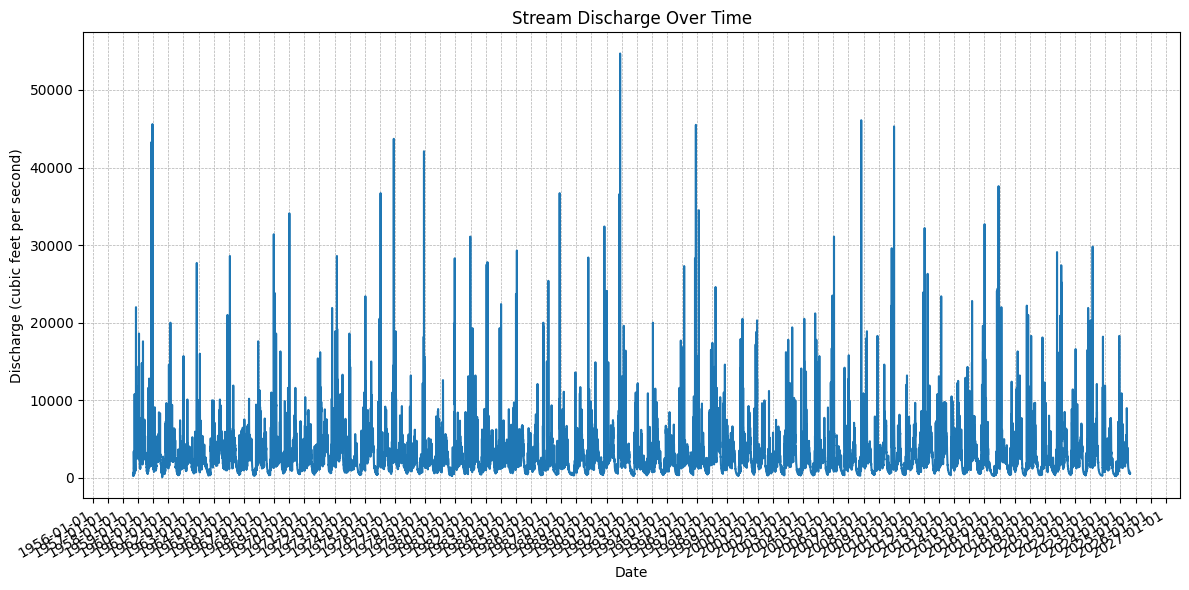

In [76]:

# Assuming your DataFrame is named 'data' and has a DateTimeIndex
# If it's not, you can set the index with: data.set_index('date', inplace=True)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(data.index, data['discharge_cfs'])

# Set the title and labels
ax.set_title('Stream Discharge Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cubic feet per second)')

# Format the x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Add a grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# ax.set_yscale('log')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Optionally, save the plot to a file
# fig.savefig('streamflow_plot.png', dpi=300, bbox_inches='tight')

In [77]:

# Assuming your DataFrame is named 'data' with a DateTimeIndex and 'discharge_cfs' column

# Step 1: Add 'day_of_year' column (ignoring Feb 29)
data['day_of_year'] = data.index.dayofyear
data.loc[data.index.month >= 3, 'day_of_year'] -= 1

# Step 2: Add 'year_number' column
data['year_number'] = data.index.year - data.index.year.min()

data

,discharge_cfs,day_of_year,year_number
date,,,
1958-09-01,412.0,243,0
1958-09-02,662.0,244,0
1958-09-03,402.0,245,0
1958-09-04,348.0,246,0
1958-09-05,343.0,247,0
...,...,...,...
2024-08-19,630.0,231,66
2024-08-20,576.0,232,66
2024-08-21,569.0,233,66


In [78]:
data.query('day_of_year == 100')

,discharge_cfs,day_of_year,year_number
date,,,
1959-04-11,2720.0,100,1
1960-04-10,3540.0,100,2
1961-04-11,2840.0,100,3
1962-04-11,2450.0,100,4
1963-04-11,2270.0,100,5
...,...,...,...
2020-04-10,2000.0,100,62
2021-04-11,1710.0,100,63
2022-04-11,2370.0,100,64


In [79]:
# Step 3: Build 2D array of streamflows
days = 365
years = data['year_number'].max() + 1
streamflow_array = np.full((days, years), np.nan)

for _, row in data.iterrows():
    day = int(row['day_of_year']) - 1  # 0-based index
    year = int(row['year_number'])
    streamflow_array[day, year] = row['discharge_cfs']

[Text(15, 0, 'Jan'),
 Text(45, 0, 'Feb'),
 Text(74, 0, 'Mar'),
 Text(105, 0, 'Apr'),
 Text(135, 0, 'May'),
 Text(166, 0, 'Jun'),
 Text(196, 0, 'Jul'),
 Text(227, 0, 'Aug'),
 Text(258, 0, 'Sep'),
 Text(288, 0, 'Oct'),
 Text(319, 0, 'Nov'),
 Text(349, 0, 'Dec')]

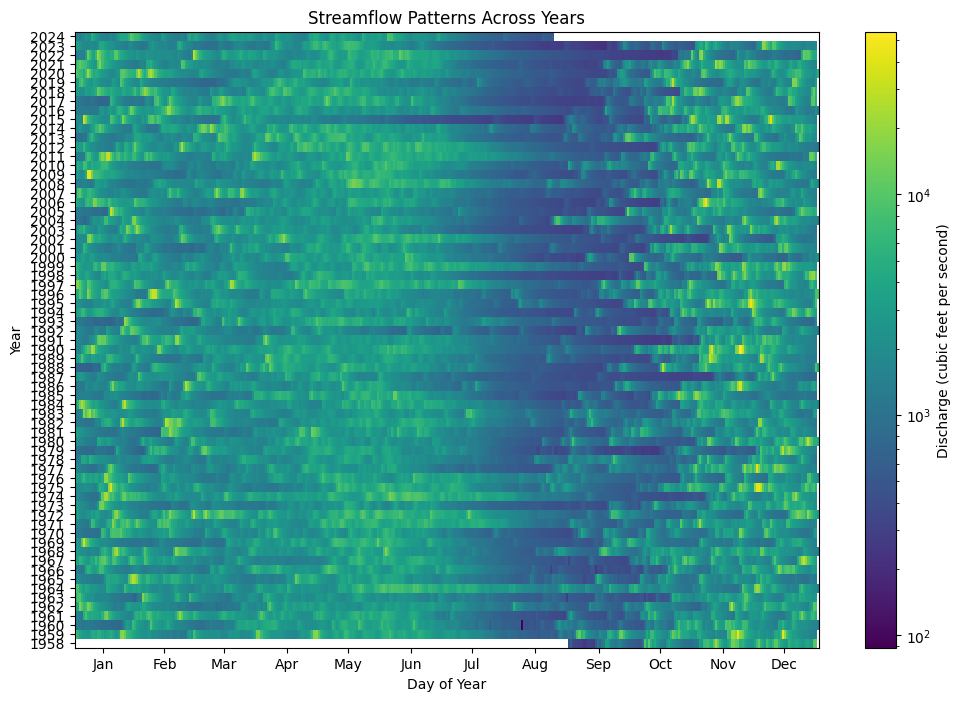

In [80]:
# Step 4: Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the streamflow array as an image
im = ax.imshow(streamflow_array.T, aspect='auto', origin='lower', 
               extent=[1, 366, 0, years], cmap='viridis', 
               norm=LogNorm(vmin=np.nanmin(streamflow_array), vmax=np.nanmax(streamflow_array)), interpolation='none')

# Customize the plot
ax.set_title('Streamflow Patterns Across Years')
ax.set_ylabel('Year')
ax.set_xlabel('Day of Year')

# Add colorbar
cbar = fig.colorbar(im, ax=ax, label='Discharge (cubic feet per second)')

# Set x-ticks to show actual years
years_range = range(data.index.year.min(), data.index.year.max() + 1)
ax.set_yticks(np.arange(years) + 0.5)
ax.set_yticklabels(years_range, rotation=0, ha='right')

# Set y-ticks to show months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_positions = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
ax.set_xticks(month_positions)
ax.set_xticklabels(months)



<Axes: xlabel='day_of_year', ylabel='discharge_cfs'>

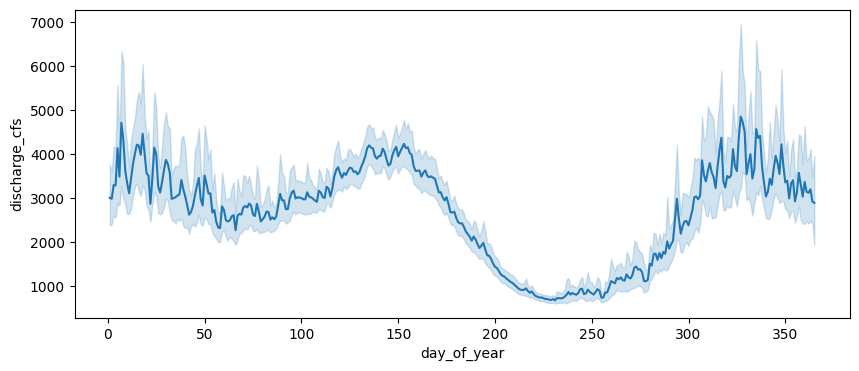

In [81]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    data = data,
    x='day_of_year',
    y='discharge_cfs',
    ax=ax,
)

In [82]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [90]:
pipeline_base = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

Error while downloading from https://cdn-lfs-us-1.huggingface.co/repos/c9/94/c99420ca621c252bb81b1d531b0eef6a72b3a43ea48538ab2871cbd6a494555b/44a2eef44aa13d9048a625ea289beb1ea5d709d7b2044f72134c974132644bf2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1724792373&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDc5MjM3M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2M5Lzk0L2M5OTQyMGNhNjIxYzI1MmJiODFiMWQ1MzFiMGVlZjZhNzJiM2E0M2VhNDg1MzhhYjI4NzFjYmQ2YTQ5NDU1NWIvNDRhMmVlZjQ0YWExM2Q5MDQ4YTYyNWVhMjg5YmViMWVhNWQ3MDlkN2IyMDQ0ZjcyMTM0Yzk3NDEzMjY0NGJmMj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=salz5Gdv1GkHgZrvhcub6V55L2nuYBj7RAcQSVcgLtB4bBhSuFRfeMD4USlWgwd9ZdxKbEwDIqbgrkmVCDp7TS6mysZ9G6q-N05c%7Esbe5CA6OGJikVrsjgzmy4%7EKB5X-HGAj8ZETTO4InurooKh4Rk-GQy4iXOnxMQD6IgMzUZ91M7Ixpq045prh7%7EwLYrotj3dORi5vmxBp8lPQTUQ8gvbsE-h9QzKdmy%7EanxV

ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs-us-1.huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b8c132af-a057-44e3-a1b0-63aab08373f6)')

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

def get_forecast_dataframe(input_date, num_samples, prediction_length, pipeline, data):
    # Convert input_date to datetime if it's a string
    if isinstance(input_date, str):
        input_date = pd.to_datetime(input_date)

    # Generate forecast
    forecast = pipeline.predict(
        context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),
        prediction_length=prediction_length,
        num_samples=num_samples,
        limit_prediction_length=False,
    )

    # Initialize lists to store data
    dates = []
    predicted_flows = []
    forecast_days = []
    prediction_numbers = []

    # Process the forecast tensor
    for sample in range(num_samples):
        for day in range(prediction_length):
            dates.append(input_date + timedelta(days=day+1))
            predicted_flows.append(forecast[0, sample, day].item())
            forecast_days.append(day)
            prediction_numbers.append(sample)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'predicted_flow': predicted_flows,
        'forecast_day': forecast_days,
        'prediction_number': prediction_numbers
    })

    # Ensure 'date' is datetime type and set as index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    return df


def calculate_historical_median(data):
    # Create a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Add day of year column
    data_copy['day_of_year'] = data_copy.index.dayofyear
    
    # Group by day of year and calculate mean
    historical_median = data_copy.groupby('day_of_year')['discharge_cfs'].median()
    
    # Function to map day of year to the average
    def get_historical_median(date):
        return historical_median[date.dayofyear]
    
    # Apply the function to all dates in the original data
    historical_median_series = data.index.to_series().apply(get_historical_median)
    historical_median_series.index = data.index
    
    return historical_median_series

def plot_streamflow_forecast(data, forecast_df, history_to_plot):
    # Infer date and prediction_length from forecast_df
    date = forecast_df.index.min() - timedelta(days=1)
    prediction_length = len(forecast_df.index.unique())
    
    # Calculate historical average
    historical_median = calculate_historical_median(data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot historical data
    historical_data = data[data.index >= date - timedelta(days=history_to_plot)]
    historical_data = historical_data[historical_data.index <= date]
    ax.plot(historical_data.index, historical_data['discharge_cfs'], color='black', label=f'Actual flow over past {history_to_plot} days')
    
    # Plot historical average
    historical_avg_plot = historical_median[historical_median.index.isin(historical_data.index) | 
                                             historical_median.index.isin(forecast_df.index)]
    ax.plot(historical_avg_plot.index, historical_avg_plot.values, color='blue', linestyle='--', label='Historical Average')
    
    # Plot forecast using Seaborn
    sns.lineplot(
        data=forecast_df,
        x=forecast_df.index,
        y='predicted_flow',
        color='red',
        ax=ax,
        label='Forecast'
    )
    
    # Plot actual future data if it exists, limited to prediction length
    future_end_date = date + timedelta(days=prediction_length)
    future_data = data[(data.index > date) & (data.index <= future_end_date)]
    if not future_data.empty:
        ax.plot(future_data.index, future_data['discharge_cfs'], color='gray', label='Actual Future Data')
    
    # Customize the plot
    ax.set_title(f'Streamflow Forecast from {date.date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')
    ax.legend()
    
    # Format x-axis to show dates nicely
    fig.autofmt_xdate()
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set x-axis limits
    ax.set_xlim(date - timedelta(days=history_to_plot), future_end_date)
    
    plt.tight_layout()
    return fig, ax

def get_and_plot_forecast(data, date, num_samples, prediction_length, history_to_plot, pipeline):
    # Get forecast
    forecast_df = get_forecast_dataframe(date, num_samples, prediction_length, pipeline, data)
    
    # Plot forecast
    fig, ax = plot_streamflow_forecast(data, forecast_df, history_to_plot)
    
    return fig, ax, forecast_df


In [84]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline, 
    data=data
)


/var/folders/f3/vgz_zf3j32d2czxk5fb8z5l40000gn/T/ipykernel_3937/2582719317.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


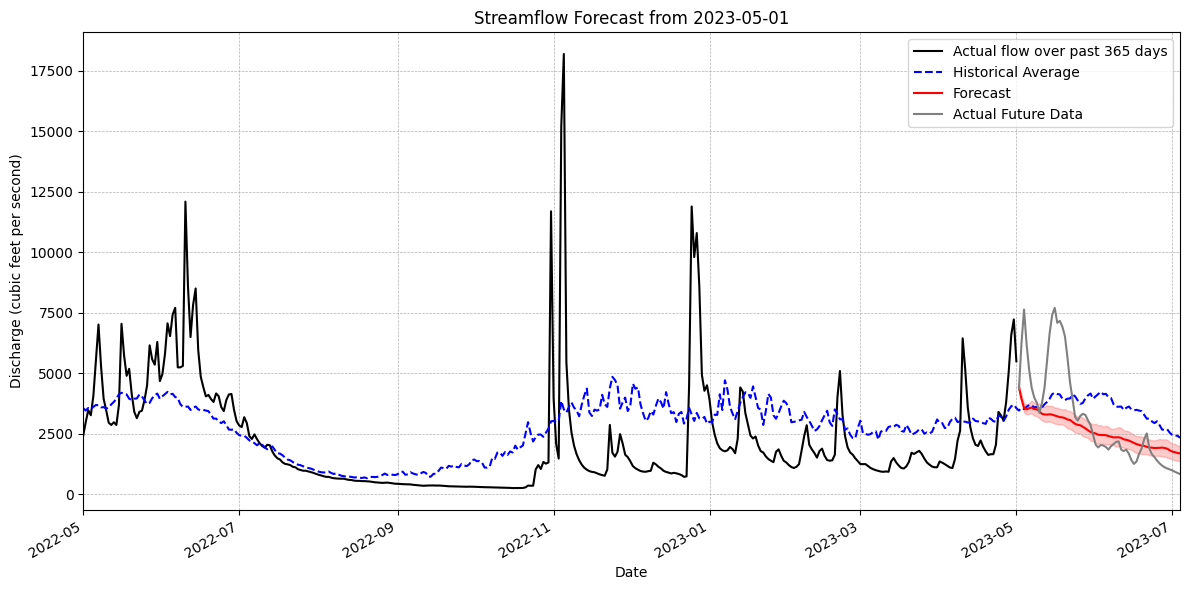

In [85]:
fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


In [86]:
forecast_df = get_forecast_dataframe(
    input_date='2024-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline, 
    data=data
)

/var/folders/f3/vgz_zf3j32d2czxk5fb8z5l40000gn/T/ipykernel_3937/2582719317.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


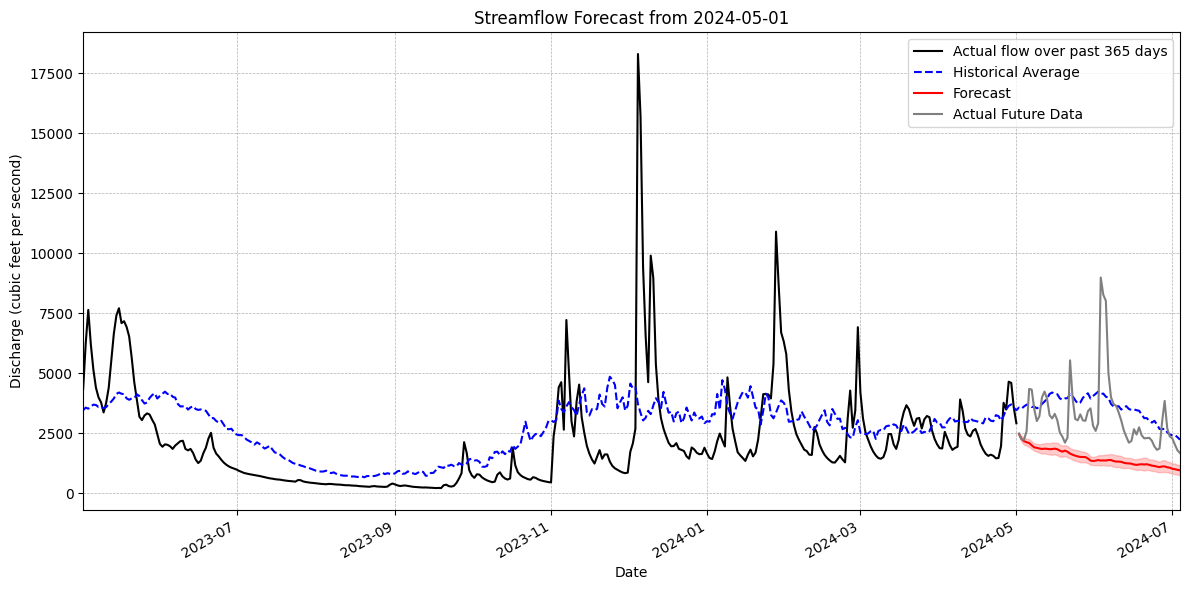

In [87]:
fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


/var/folders/f3/vgz_zf3j32d2czxk5fb8z5l40000gn/T/ipykernel_3937/2582719317.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


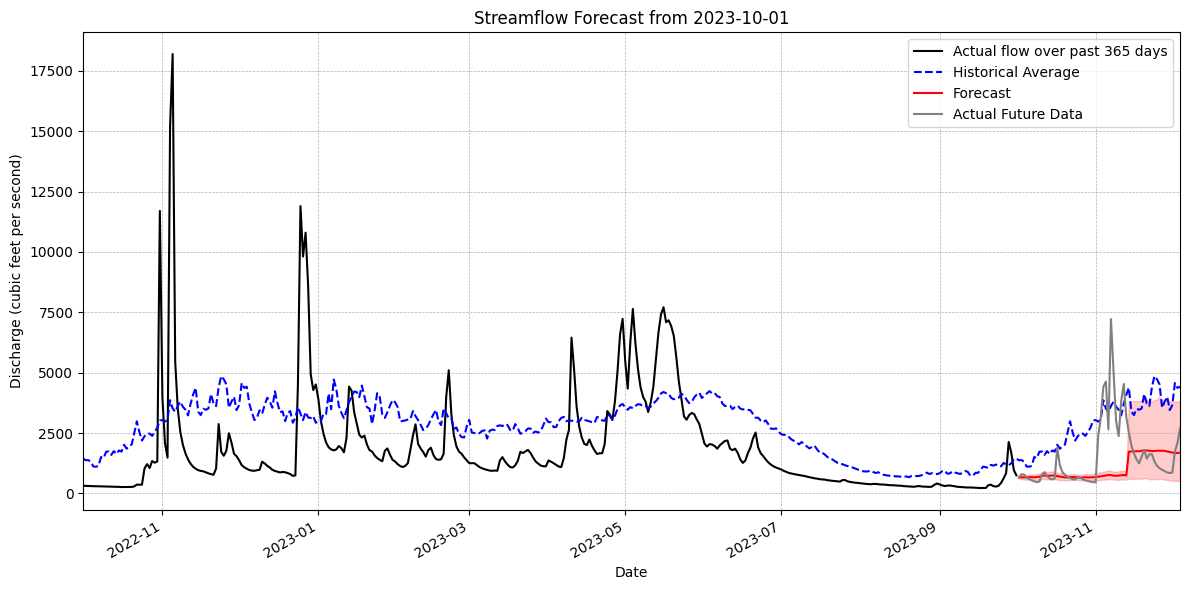

In [89]:
forecast_df = get_forecast_dataframe(
    input_date='2023-10-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)